# Assignment-1 (KNN Classifier)-Part-A
## Handwritten digit recognition
In this assignment part-A, we will use the built-in library ``sklearn`` to use KNN classifier.

## The MNIST dataset
`MNIST` is a classic dataset in machine learning, consisting of 28x28 gray-scale images handwritten digits. The training set contains 60,000 examples and the test set contains 10,000 examples. In this assignment we will further split the training set to take out 12,000 examples as a validation step.

In [1]:
%matplotlib inline
import gzip, os
import numpy as np
import matplotlib.pyplot as plt
import time
from urllib.request import urlretrieve

In [2]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

In [3]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [4]:
## Print out their dimensions
print("Training dataset dimensions: ", np.shape(train_data))
print("Number of training labels: ", len(train_labels))
print("Testing dataset dimensions: ", np.shape(test_data))
print("Number of testing labels: ", len(test_labels))

Training dataset dimensions:  (60000, 784)
Number of training labels:  60000
Testing dataset dimensions:  (10000, 784)
Number of testing labels:  10000


In [5]:
## Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))

Training set distribution:
{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test set distribution:
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


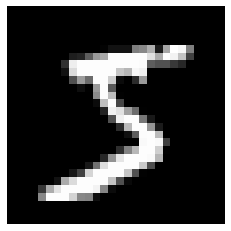

Label 5


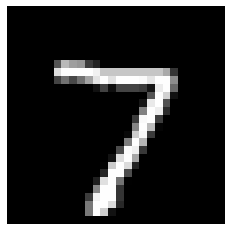

Label 7


In [6]:
## Define a function that displays a digit given its vector representation
def show_digit(x):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train"):
    if(dataset=="train"): 
        show_digit(train_data[index,])
        label = train_labels[index]
    else:
        show_digit(test_data[index,])
        label = test_labels[index]
    print("Label " + str(label))
    return

## View the first data point in the training set
vis_image(0, "train")

## Now view the first data point in the test set
vis_image(0, "test")

## Splitting the Train data to Train and Validate Sets

In [7]:
from sklearn.model_selection import train_test_split
trainx, valx, trainy, valy = train_test_split(train_data, train_labels, test_size=0.20, random_state=42)

## 1. K-Nearest neighbor classifier--Brute Force Approach

Use the built-in KNN classifier to perform handwritten digit classification task. Please keep in mind that any hyper-parameter selection shall be performed on the independent validation set and not on the test set. You need to study the KNeighborsClassifier documentation to understand how to use the api with different parameters. In this set of experiments, you need to select 'brute' for the **algorithm** parameter. Record the error rates on the test set and the cpu time taken for evaluation.

**Note:** Here you don't have to implement the KNN classifier but you just need to use it from ``sklearn`` library.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
### START CODE HERE ###
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

# Function to train and evaluate KNN model
def train_evaluate_knn(k, X_train, y_train, X_val, y_val):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    knn.fit(X_train, y_train)
    val_predictions = knn.predict(X_val)
    return accuracy_score(y_val, val_predictions)

# List of k values to try
k_values = [1, 3, 5, 7, 9]

# Find the best k using validation set
best_k = 0
best_accuracy = 0

for k in k_values:
    accuracy = train_evaluate_knn(k, trainx, trainy, valx, valy)
    print(f"k={k}, Validation Accuracy: {accuracy:.4f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"\nBest k: {best_k}")

# Train the final model with the best k
best_knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
best_knn.fit(trainx, trainy)

# Evaluate on test set
start_time = time.time()
test_predictions = best_knn.predict(test_data)
end_time = time.time()

test_accuracy = accuracy_score(test_labels, test_predictions)
test_error_rate = 1 - test_accuracy
cpu_time = end_time - start_time

print(f"\nTest Error Rate: {test_error_rate:.4f}")
print(f"CPU Time for Evaluation: {cpu_time:.4f} seconds")
### END CODE HERE ###

k=1, Validation Accuracy: 0.9741
k=3, Validation Accuracy: 0.9727
k=5, Validation Accuracy: 0.9715
k=7, Validation Accuracy: 0.9696
k=9, Validation Accuracy: 0.9673

Best k: 1

Test Error Rate: 0.0327
CPU Time for Evaluation: 8.9578 seconds


## 2. Faster nearest neighbor methods

Performing nearest neighbor classification in the way we have presented requires a full pass through the training set in order to classify a single point. If there are $N$ training points in $\mathbb{R}^d$, this takes $O(N d)$ time.

Fortunately, there are faster methods to perform nearest neighbor look up if we are willing to spend some time preprocessing the training set. `scikit-learn` has fast implementations of two useful nearest neighbor data structures: the _ball tree_ and the _k-d tree_. Record the error rates on the test set and the cpu time taken for evaluation using these two faster methods.

**Note:** You need to select 'ball_tree'or 'kd_tree' for the **algorithm** parameter for ``KNeighborsClassifier`` classifier.

In [10]:
# You can use KNeighborsClassifier with correct values for 'algorithm'
### START CODE HERE ###
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

# Function to evaluate KNN with different algorithms
def evaluate_knn(algorithm, X_train, y_train, X_test, y_test, k):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm=algorithm)
    
    # Training time
    train_start = time.time()
    knn.fit(X_train, y_train)
    train_time = time.time() - train_start
    
    # Testing time
    test_start = time.time()
    test_predictions = knn.predict(X_test)
    test_time = time.time() - test_start
    
    # Calculate error rate
    error_rate = 1 - accuracy_score(y_test, test_predictions)
    
    return error_rate, train_time, test_time

# List of algorithms to try
algorithms = ['brute', 'ball_tree', 'kd_tree']
k = 5  # You can adjust this value based on your previous findings

# Evaluate each algorithm
for alg in algorithms:
    error_rate, train_time, test_time = evaluate_knn(alg, train_data, train_labels, test_data, test_labels, k)
    print(f"\nAlgorithm: {alg}")
    print(f"Error Rate: {error_rate:.4f}")
    print(f"Training Time: {train_time:.4f} seconds")
### END CODE HERE ###


Algorithm: brute
Error Rate: 0.0312
Training Time: 0.0032 seconds

Algorithm: ball_tree
Error Rate: 0.0312
Training Time: 17.6852 seconds

Algorithm: kd_tree
Error Rate: 0.0312
Training Time: 23.6659 seconds


## 3. Record CPU time and accuracy for all the three approaches in different datasets

Use brute-force, kd-tree, and ball-tree approaches for the following datasets and record the accuracies and cpu time (for evaluation step only). Looking at the results, can you explain it.

Datasets:
1. Abalone Data Set (https://archive.ics.uci.edu/ml/datasets/abalone)
2. Statlog (Landsat Satellite) Data Set (https://archive.ics.uci.edu/ml/datasets/Statlog+(Landsat+Satellite))

**Note:** The datasets are provided as attachement in the assignment as CSV files.

In [16]:
# You can use KNeighborsClassifier with correct values for 'algorithm'
### START CODE HERE ###
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import time

def load_and_preprocess_data(file_path, column_names, target_column):
    # Load the data with provided column names
    data = pd.read_csv(file_path, names=column_names)
    
    # Separate features and target
    X = data.drop(target_column, axis=1)
    y = data[target_column]
    
    # Encode categorical variables
    le = LabelEncoder()
    for column in X.select_dtypes(include=['object']):
        X[column] = le.fit_transform(X[column])
    y = le.fit_transform(y)
    
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y

def evaluate_knn(X_train, X_test, y_train, y_test, algorithm, k=5):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm=algorithm)
    knn.fit(X_train, y_train)
    
    # Measure evaluation time
    start_time = time.time()
    y_pred = knn.predict(X_test)
    eval_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, eval_time

# Load and preprocess datasets
abalone_columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 
                   'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

satellite_columns = [f'band_{i}' for i in range(1, 37)] + ['Class']

# Load and preprocess datasets
abalone_X, abalone_y = load_and_preprocess_data('abalone19.csv', abalone_columns, 'Rings')
satellite_X, satellite_y = load_and_preprocess_data('186_satimage.csv', satellite_columns, 'Class')

datasets = [
    ("Abalone", abalone_X, abalone_y),
    ("Satellite", satellite_X, satellite_y)
]

algorithms = ['brute', 'kd_tree', 'ball_tree']

results = []

for dataset_name, X, y in datasets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for algorithm in algorithms:
        accuracy, eval_time = evaluate_knn(X_train, X_test, y_train, y_test, algorithm)
        results.append({
            'Dataset': dataset_name,
            'Algorithm': algorithm,
            'Accuracy': accuracy,
            'Evaluation Time': eval_time
        })

# Display results
results_df = pd.DataFrame(results)
print(results_df)

# Analyze results
for dataset in ['Abalone', 'Satellite']:
    print(f"\nAnalysis for {dataset} dataset:")
    dataset_results = results_df[results_df['Dataset'] == dataset]
    fastest_algo = dataset_results.loc[dataset_results['Evaluation Time'].idxmin()]
    most_accurate_algo = dataset_results.loc[dataset_results['Accuracy'].idxmax()]
    
    print(f"Fastest algorithm: {fastest_algo['Algorithm']} (Time: {fastest_algo['Evaluation Time']:.4f}s)")
    print(f"Most accurate algorithm: {most_accurate_algo['Algorithm']} (Accuracy: {most_accurate_algo['Accuracy']:.4f})")
### END CODE HERE ###

     Dataset  Algorithm  Accuracy  Evaluation Time
0    Abalone      brute  0.226077         0.073206
1    Abalone    kd_tree  0.226077         0.020559
2    Abalone  ball_tree  0.226077         0.025656
3  Satellite      brute  0.912908         0.117715
4  Satellite    kd_tree  0.912908         0.142253
5  Satellite  ball_tree  0.912908         0.130483

Analysis for Abalone dataset:
Fastest algorithm: kd_tree (Time: 0.0206s)
Most accurate algorithm: brute (Accuracy: 0.2261)

Analysis for Satellite dataset:
Fastest algorithm: brute (Time: 0.1177s)
Most accurate algorithm: brute (Accuracy: 0.9129)


## E1. Extra Stuff

You are invited to try some more ideas as extra work like:
1. Instead of using the pixels as features, implement your own features (example: what were presented in the slides) and use them for KNN. You need to keep in mind that if you compute features which have different scales then it is important to scale/normalize the features (discussed in the slides).

In [17]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import time

def extract_features(images):
    features = []
    for image in images:
        img = image.reshape(28, 28)
        
        # Feature 1: Mean intensity
        mean_intensity = np.mean(img)
        
        # Feature 2: Standard deviation of intensity
        std_intensity = np.std(img)
        
        # Feature 3: Horizontal symmetry
        h_symmetry = np.mean(np.abs(img[:, :14] - np.fliplr(img[:, 14:])))
        
        # Feature 4: Vertical symmetry
        v_symmetry = np.mean(np.abs(img[:14, :] - np.flipud(img[14:, :])))
        
        # Feature 5: Number of pixels above mean intensity
        above_mean = np.sum(img > mean_intensity) / img.size
        
        # Feature 6: Ratio of non-zero pixels
        non_zero_ratio = np.count_nonzero(img) / img.size
        
        # Feature 7-10: Intensity of four quadrants
        quadrants = [img[:14, :14], img[:14, 14:], img[14:, :14], img[14:, 14:]]
        quadrant_intensities = [np.mean(q) for q in quadrants]
        
        features.append([mean_intensity, std_intensity, h_symmetry, v_symmetry, 
                         above_mean, non_zero_ratio] + quadrant_intensities)
    
    return np.array(features)

def evaluate_knn(X_train, X_test, y_train, y_test, algorithm, k=5):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm=algorithm)
    knn.fit(X_train, y_train)
    
    # Measure evaluation time
    start_time = time.time()
    y_pred = knn.predict(X_test)
    eval_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, eval_time

# Extract features from the MNIST dataset
X_features = extract_features(train_data)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, train_labels, test_size=0.2, random_state=42)

algorithms = ['brute', 'kd_tree', 'ball_tree']
results = []

for algorithm in algorithms:
    accuracy, eval_time = evaluate_knn(X_train, X_test, y_train, y_test, algorithm)
    results.append({
        'Algorithm': algorithm,
        'Accuracy': accuracy,
        'Evaluation Time': eval_time
    })

# Display results
print("Results with custom features:")
for result in results:
    print(f"Algorithm: {result['Algorithm']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Evaluation Time: {result['Evaluation Time']:.4f} seconds")
    print()

# Compare with original pixel-based approach
X_pixel_train, X_pixel_test, y_pixel_train, y_pixel_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
pixel_accuracy, pixel_eval_time = evaluate_knn(X_pixel_train, X_pixel_test, y_pixel_train, y_pixel_test, 'kd_tree')

print("Results with original pixels:")
print(f"Accuracy: {pixel_accuracy:.4f}")
print(f"Evaluation Time: {pixel_eval_time:.4f} seconds")

Results with custom features:
Algorithm: brute
Accuracy: 0.5375
Evaluation Time: 8.3141 seconds

Algorithm: kd_tree
Accuracy: 0.5375
Evaluation Time: 0.7418 seconds

Algorithm: ball_tree
Accuracy: 0.5375
Evaluation Time: 2.4309 seconds

Results with original pixels:
Accuracy: 0.9715
Evaluation Time: 613.7484 seconds


## Points to remember

You need to keep in mind the following points:
1. Use numpy arrays and numpy libraries for efficient computations. 